In [1]:
#load package
using Revise
using Plots
using LaTeXStrings
using LinearAlgebra
using SparseIR
using Nevanlinna

In [2]:
# Set work data Type
T = BigFloat
setprecision(128)
;

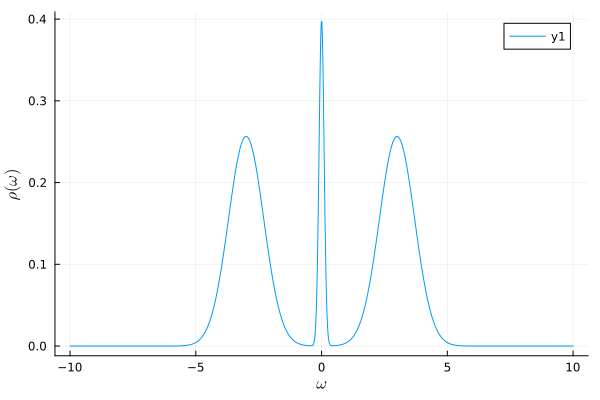

In [17]:
#define spectral function
gaussian(x, mu, sigma) = exp(-0.5*((x-mu)/sigma)^2)/(sqrt(2*π)*sigma)
rho(omega) = 0.45*gaussian(omega, -3.0, 0.7) + 0.1*gaussian(omega, 0.0, 0.1) + 0.45*gaussian(omega, 3, 0.7)
omegas = LinRange(-10, 10, 1000)
plot()
plot!(omegas, rho.(omegas), xlabel=latexstring("\\omega"), ylabel=latexstring("\\rho(\\omega)"))

In [21]:
function generate_input_data(rho::Function, beta::Float64)
    lambda = 1e+4
    wmax = lambda/beta
    basis = FiniteTempBasisSet(beta, wmax, 1e-15)

    rhol = [overlap(basis.basis_f.v[l], rho) for l in 1:length(basis.basis_f)]
    gl = - basis.basis_f.s .* rhol
    gw = evaluate(basis.smpl_wn_f, gl)
    
    hnw = length(basis.smpl_wn_f.sampling_points)÷2
    
    input_smpl = Array{Complex{T}}(undef, hnw) 
    input_gw   = Array{Complex{T}}(undef, hnw) 
    
    for i in 1:hnw
        input_smpl[i]= SparseIR.valueim(basis.smpl_wn_f.sampling_points[hnw+i], beta)
        input_gw[i]  = gw[hnw+i]
    end
    
    return input_smpl, input_gw
end

generate_input_data (generic function with 1 method)

In [22]:
beta = 100. #inverse temperature
input_smpl, input_gw = generate_input_data(rho, beta)
;

In [20]:
N_real    = 1000  #demension of array of output
omega_max = 10.0  #energy cutoff of real axis
eta       = 0.001 #broaden parameter 
sum_rule  = 1.0   #sum rule
H_max     = 50    #cutoff of Hardy basis
lambda    = 1e-4  #regularization parameter
iter_tol  = 1000  #upper bound of iteration
;

In [26]:
#construct solver struct
@time sol = Nevanlinna.NevanlinnaSolver(input_smpl, input_gw, N_real, omega_max, eta, sum_rule, H_max, iter_tol, lambda, verbose=true)
;

N_imag is setted as 31
H=1
Iter     Function value   Gradient norm 
     0     8.352772e+00     7.813300e+00
 * time: 0.013830900192260742
     1     8.151464e+00     6.270409e+00
 * time: 0.8706140518188477
     2     7.874941e+00     4.734793e+00
 * time: 1.208517074584961
     3     6.819553e+00     1.013432e+01
 * time: 1.483280897140503
     4     6.661997e+00     8.222311e+00
 * time: 1.5848290920257568
     5     6.276897e+00     8.734672e+00
 * time: 1.7154979705810547
     6     6.119534e+00     3.604827e+00
 * time: 1.849790096282959
     7     6.097378e+00     7.156467e-01
 * time: 1.9903600215911865
     8     6.094827e+00     2.555365e-01
 * time: 2.170380115509033
     9     6.094641e+00     1.900900e-01
 * time: 2.312001943588257
    10     6.094545e+00     3.925372e-02
 * time: 2.4137020111083984
    11     6.094539e+00     3.249677e-02
 * time: 2.631171941757202
    12     6.094537e+00     1.350328e-02
 * time: 2.732815980911255
    13     6.094536e+00     8.374270e-03

In [27]:
#execute optimize
@time Nevanlinna.solve!(sol)

H=1
Iter     Function value   Gradient norm 
     0     6.094536e+00     7.070689e-09
 * time: 0.000164031982421875
max_theta=0.2685524190519847697563537445142900497278
hardy optimization was success.
H=2
Iter     Function value   Gradient norm 
     0     6.094536e+00     1.139667e+01
 * time: 0.0001659393310546875
     1     5.641209e+00     1.805460e+01
 * time: 0.3506319522857666
     2     4.984890e+00     1.409236e+01
 * time: 0.7416810989379883
     3     9.915910e-01     1.418209e+01
 * time: 1.090419054031372
     4     5.730849e-01     9.866714e-01
 * time: 1.294114112854004
     5     5.698439e-01     1.233550e+00
 * time: 1.4358570575714111
     6     5.609294e-01     6.909218e-01
 * time: 1.575058937072754
     7     5.535693e-01     4.062837e-01
 * time: 1.719649076461792
     8     5.493648e-01     6.292626e-01
 * time: 1.868704080581665
     9     5.470719e-01     2.762929e-01
 * time: 2.016658067703247
    10     5.465677e-01     5.312929e-02
 * time: 2.141704082489013

    61     1.788925e-01     4.864663e-08
 * time: 12.496242046356201
    62     1.788925e-01     5.100334e-08
 * time: 12.757960081100464
    63     1.788925e-01     2.452618e-08
 * time: 12.920229196548462
    64     1.788925e-01     2.971716e-08
 * time: 13.153381109237671
    65     1.788925e-01     1.446371e-08
 * time: 13.317443132400513
    66     1.788925e-01     1.645126e-08
 * time: 13.548196077346802
    67     1.788925e-01     8.415591e-09
 * time: 13.706264019012451
max_theta=0.7286888799243556700848721168537732479253
hardy optimization was success.
H=4
Iter     Function value   Gradient norm 
     0     1.788925e-01     5.338908e-01
 * time: 0.00018310546875
     1     1.768687e-01     7.192032e-01
 * time: 0.2306981086730957
     2     1.749611e-01     8.411092e-01
 * time: 0.5521411895751953
     3     1.138976e-01     2.815506e+00
 * time: 0.7150812149047852
     4     1.078929e-01     2.405455e+00
 * time: 0.9814832210540771
     5     1.056078e-01     2.144346e+00
 * 

    24     2.638067e-02     1.435471e-02
 * time: 5.101899862289429
    25     2.637652e-02     2.667880e-02
 * time: 5.3811750411987305
    26     2.637441e-02     7.383859e-03
 * time: 5.55339789390564
    27     2.637269e-02     1.625448e-02
 * time: 5.7935919761657715
    28     2.637183e-02     8.081824e-03
 * time: 5.967267036437988
    29     2.637028e-02     1.801066e-02
 * time: 6.243453025817871
    30     2.636935e-02     1.199729e-02
 * time: 6.409096956253052
    31     2.636801e-02     1.816158e-02
 * time: 6.646301984786987
    32     2.636731e-02     1.280421e-02
 * time: 6.8308329582214355
    33     2.636611e-02     2.104532e-02
 * time: 7.127450942993164
    34     2.636548e-02     1.745435e-02
 * time: 7.310173988342285
    35     2.636393e-02     2.023523e-02
 * time: 7.622819900512695
    36     2.636317e-02     1.806609e-02
 * time: 7.906367063522339
    37     2.636179e-02     1.734942e-02
 * time: 8.236625909805298
    38     2.636105e-02     1.916849e-02
 * ti

    27     2.264696e-02     1.085623e-02
 * time: 5.58002495765686
    28     2.264329e-02     3.664603e-02
 * time: 5.8212480545043945
    29     2.264043e-02     1.548009e-02
 * time: 5.987733840942383
    30     2.263614e-02     3.915935e-02
 * time: 6.249268054962158
    31     2.263322e-02     2.067608e-02
 * time: 6.421871900558472
    32     2.262884e-02     3.823226e-02
 * time: 6.6911749839782715
    33     2.262534e-02     2.264548e-02
 * time: 6.861024856567383
    34     2.262115e-02     3.092021e-02
 * time: 7.102356910705566
    35     2.261756e-02     2.905204e-02
 * time: 7.271564960479736
    36     2.261428e-02     2.726080e-02
 * time: 7.444001913070679
    37     2.261031e-02     3.976783e-02
 * time: 7.705579996109009
    38     2.260732e-02     3.609466e-02
 * time: 7.870117902755737
    39     2.260073e-02     2.879527e-02
 * time: 8.140151023864746
    40     2.259698e-02     2.755835e-02
 * time: 8.38388991355896
    41     2.259099e-02     2.019553e-02
 * time

   147     2.256871e-02     5.183513e-07
 * time: 30.396079063415527
   148     2.256871e-02     2.558282e-07
 * time: 30.56656503677368
   149     2.256871e-02     4.137099e-07
 * time: 30.84818696975708
   150     2.256871e-02     2.038047e-07
 * time: 31.02274203300476
   151     2.256871e-02     3.190020e-07
 * time: 31.267257928848267
   152     2.256871e-02     1.516572e-07
 * time: 31.493720054626465
   153     2.256871e-02     2.380293e-07
 * time: 31.667952060699463
   154     2.256871e-02     1.156618e-07
 * time: 31.867835998535156
   155     2.256871e-02     1.725771e-07
 * time: 32.119744062423706
   156     2.256871e-02     8.760380e-08
 * time: 32.29337000846863
   157     2.256871e-02     1.318546e-07
 * time: 32.57222604751587
   158     2.256871e-02     6.379954e-08
 * time: 32.751030921936035
   159     2.256871e-02     1.082915e-07
 * time: 33.01018190383911
   160     2.256871e-02     5.057609e-08
 * time: 33.18096303939819
   161     2.256871e-02     8.711861e-08


    92     2.095805e-02     1.156170e-02
 * time: 18.590821981430054
    93     2.095782e-02     4.334206e-03
 * time: 18.78322196006775
    94     2.095762e-02     1.061738e-02
 * time: 18.99537205696106
    95     2.095745e-02     5.067088e-03
 * time: 19.181243896484375
    96     2.095729e-02     9.702004e-03
 * time: 19.36588406562805
    97     2.095716e-02     5.235048e-03
 * time: 19.56154990196228
    98     2.095702e-02     8.565340e-03
 * time: 19.85323691368103
    99     2.095691e-02     5.189612e-03
 * time: 20.041051864624023
   100     2.095680e-02     7.151015e-03
 * time: 20.304574966430664
   101     2.095673e-02     5.126679e-03
 * time: 20.493890047073364
   102     2.095663e-02     5.660065e-03
 * time: 20.780375957489014
   103     2.095655e-02     4.640078e-03
 * time: 21.071300983428955
   104     2.095648e-02     5.144640e-03
 * time: 21.335731983184814
   105     2.095643e-02     4.413171e-03
 * time: 21.546685934066772
   106     2.095637e-02     5.506248e-0

   212     2.095476e-02     1.193774e-04
 * time: 42.580426931381226
   213     2.095476e-02     2.241662e-04
 * time: 42.77422595024109
   214     2.095476e-02     1.368210e-04
 * time: 43.04440903663635
   215     2.095476e-02     2.391995e-04
 * time: 43.2375168800354
   216     2.095476e-02     1.552780e-04
 * time: 43.4661078453064
   217     2.095476e-02     2.465674e-04
 * time: 43.653876066207886
   218     2.095476e-02     1.681080e-04
 * time: 43.92992186546326
   219     2.095476e-02     2.375875e-04
 * time: 44.12269401550293
   220     2.095476e-02     1.661922e-04
 * time: 44.42120599746704
   221     2.095476e-02     2.053965e-04
 * time: 44.60660791397095
   222     2.095476e-02     1.467704e-04
 * time: 44.90641784667969
   223     2.095476e-02     1.529161e-04
 * time: 45.09167695045471
   224     2.095476e-02     1.220423e-04
 * time: 45.37966990470886
   225     2.095476e-02     1.180352e-04
 * time: 45.564018964767456
   226     2.095476e-02     1.188814e-04
 * tim

   333     2.095476e-02     1.497779e-08
 * time: 66.12282800674438
   334     2.095476e-02     1.724108e-08
 * time: 66.329274892807
   335     2.095476e-02     1.283393e-08
 * time: 66.52187490463257
   336     2.095476e-02     1.489828e-08
 * time: 66.72001194953918
   337     2.095476e-02     1.124869e-08
 * time: 66.91086101531982
   338     2.095476e-02     1.301636e-08
 * time: 67.109384059906
max_theta=0.6513525697575016684312084650145511257121
hardy optimization was success.
H=8
Iter     Function value   Gradient norm 
     0     2.095476e-02     4.643985e-03
 * time: 0.0001881122589111328
     1     2.095435e-02     9.983772e-03
 * time: 0.20996999740600586
     2     2.095416e-02     5.978330e-03
 * time: 0.47411108016967773
     3     2.095401e-02     5.232365e-03
 * time: 0.6723651885986328
     4     2.095342e-02     5.283398e-03
 * time: 0.969487190246582
     5     2.094995e-02     3.352011e-02
 * time: 1.2538480758666992
     6     2.094894e-02     2.079297e-02
 * time

   112     2.049842e-02     4.094058e-03
 * time: 27.537294149398804
   113     2.049839e-02     4.494956e-03
 * time: 27.768136978149414
   114     2.049837e-02     3.483290e-03
 * time: 28.04889416694641
   115     2.049835e-02     3.749273e-03
 * time: 28.38301110267639
   116     2.049831e-02     3.726870e-03
 * time: 28.70767903327942
   117     2.049822e-02     4.145463e-03
 * time: 29.012168169021606
   118     2.049809e-02     4.205510e-03
 * time: 29.292943000793457
   119     2.049803e-02     7.649772e-03
 * time: 29.49937915802002
   120     2.049796e-02     2.988562e-03
 * time: 29.72640299797058
   121     2.049788e-02     7.505672e-03
 * time: 29.921253204345703
   122     2.049781e-02     2.979509e-03
 * time: 30.11798119544983
   123     2.049772e-02     7.371723e-03
 * time: 30.314823150634766
   124     2.049764e-02     2.405341e-03
 * time: 30.51813507080078
   125     2.049758e-02     6.197202e-03
 * time: 30.73498010635376
   126     2.049753e-02     1.807067e-03
 

   232     2.049635e-02     5.867457e-04
 * time: 54.36674118041992
   233     2.049635e-02     9.420204e-04
 * time: 54.669363021850586
   234     2.049635e-02     6.263105e-04
 * time: 54.862980127334595
   235     2.049635e-02     9.599313e-04
 * time: 55.15479016304016
   236     2.049635e-02     6.652003e-04
 * time: 55.379475116729736
   237     2.049635e-02     9.755453e-04
 * time: 55.66874313354492
   238     2.049635e-02     7.028728e-04
 * time: 55.897008180618286
   239     2.049635e-02     9.925213e-04
 * time: 56.2043240070343
   240     2.049635e-02     7.388534e-04
 * time: 56.40422606468201
   241     2.049635e-02     1.015937e-03
 * time: 56.70926904678345
   242     2.049635e-02     7.783704e-04
 * time: 56.905954122543335
   243     2.049635e-02     1.042519e-03
 * time: 57.21502709388733
   244     2.049635e-02     8.216071e-04
 * time: 57.40974807739258
   245     2.049635e-02     1.044958e-03
 * time: 57.732861042022705
   246     2.049635e-02     8.463265e-04
 *

     6     2.049596e-02     8.179114e-03
 * time: 1.37221097946167
     7     2.049579e-02     5.789885e-03
 * time: 1.5927929878234863
     8     2.049553e-02     9.796336e-03
 * time: 1.8040030002593994
     9     2.049520e-02     6.997465e-03
 * time: 2.0204479694366455
    10     2.049486e-02     8.244846e-03
 * time: 2.2435920238494873
    11     2.049430e-02     8.069009e-03
 * time: 2.4893109798431396
    12     2.049382e-02     7.971085e-03
 * time: 2.7331840991973877
    13     2.049341e-02     7.832228e-03
 * time: 2.9796810150146484
    14     2.049241e-02     9.175879e-03
 * time: 3.2284018993377686
    15     2.049173e-02     7.484228e-03
 * time: 3.4813950061798096
    16     2.049147e-02     5.332852e-03
 * time: 3.7491190433502197
    17     2.049128e-02     6.268348e-03
 * time: 3.962061882019043
    18     2.049085e-02     9.033830e-03
 * time: 4.176063060760498
    19     2.049014e-02     1.034128e-02
 * time: 4.385893106460571
    20     2.048835e-02     1.345059e-0

   126     2.034409e-02     5.704179e-03
 * time: 32.386276960372925
   127     2.034403e-02     3.562854e-03
 * time: 32.59959888458252
   128     2.034398e-02     5.289207e-03
 * time: 32.80856990814209
   129     2.034393e-02     3.271283e-03
 * time: 33.01853799819946
   130     2.034389e-02     5.318194e-03
 * time: 33.257051944732666
   131     2.034384e-02     3.313348e-03
 * time: 33.47051501274109
   132     2.034377e-02     5.533940e-03
 * time: 33.6873619556427
   133     2.034370e-02     3.292078e-03
 * time: 33.8948130607605
   134     2.034361e-02     5.128713e-03
 * time: 34.10489892959595
   135     2.034352e-02     3.131279e-03
 * time: 34.34321308135986
   136     2.034342e-02     4.174960e-03
 * time: 34.555115938186646
   137     2.034334e-02     2.892455e-03
 * time: 34.77065706253052
   138     2.034327e-02     3.381536e-03
 * time: 34.97860908508301
   139     2.034321e-02     2.645145e-03
 * time: 35.18886590003967
   140     2.034315e-02     2.812816e-03
 * tim

   247     2.034126e-02     2.991284e-04
 * time: 62.084954023361206
   248     2.034126e-02     2.001642e-04
 * time: 62.29974389076233
   249     2.034126e-02     2.519215e-04
 * time: 62.52945899963379
   250     2.034126e-02     1.765668e-04
 * time: 62.78692698478699
   251     2.034126e-02     2.178511e-04
 * time: 63.028960943222046
   252     2.034126e-02     1.577528e-04
 * time: 63.27515697479248
   253     2.034125e-02     1.976927e-04
 * time: 63.51633906364441
   254     2.034125e-02     1.420272e-04
 * time: 63.728029012680054
   255     2.034125e-02     1.819845e-04
 * time: 63.96385192871094
   256     2.034125e-02     1.264313e-04
 * time: 64.17619204521179
   257     2.034125e-02     1.638095e-04
 * time: 64.39233589172363
   258     2.034125e-02     1.102950e-04
 * time: 64.603355884552
   259     2.034125e-02     1.433108e-04
 * time: 64.83210897445679
   260     2.034125e-02     9.533638e-05
 * time: 65.06720805168152
   261     2.034125e-02     1.244405e-04
 * tim

   368     2.034125e-02     1.506045e-07
 * time: 88.53713607788086
   369     2.034125e-02     1.952406e-07
 * time: 88.74834394454956
   370     2.034125e-02     1.294536e-07
 * time: 88.98533892631531
   371     2.034125e-02     1.705779e-07
 * time: 89.19695496559143
   372     2.034125e-02     1.113473e-07
 * time: 89.4085590839386
   373     2.034125e-02     1.498133e-07
 * time: 89.62016296386719
   374     2.034125e-02     9.759557e-08
 * time: 89.82984590530396
   375     2.034125e-02     1.333247e-07
 * time: 90.06746888160706
   376     2.034125e-02     8.779729e-08
 * time: 90.27865409851074
   377     2.034125e-02     1.199159e-07
 * time: 90.48941493034363
   378     2.034125e-02     7.966935e-08
 * time: 90.70118594169617
   379     2.034125e-02     1.083291e-07
 * time: 90.91129994392395
   380     2.034125e-02     7.157348e-08
 * time: 91.14909410476685
   381     2.034125e-02     9.755600e-08
 * time: 91.36193609237671
   382     2.034125e-02     6.325461e-08
 * time:

    75     2.030622e-02     6.226585e-03
 * time: 19.403496980667114
    76     2.030592e-02     2.878313e-03
 * time: 19.740156888961792
    77     2.030531e-02     7.253790e-03
 * time: 20.08446502685547
    78     2.030499e-02     4.100713e-03
 * time: 20.422631978988647
    79     2.030476e-02     2.634669e-03
 * time: 20.767112016677856
    80     2.030460e-02     2.774732e-03
 * time: 21.11223006248474
    81     2.030442e-02     2.870440e-03
 * time: 21.453521966934204
    82     2.030415e-02     6.859015e-03
 * time: 21.79438591003418
    83     2.030391e-02     4.107441e-03
 * time: 22.016917943954468
    84     2.030359e-02     6.368405e-03
 * time: 22.235485076904297
    85     2.030331e-02     3.579319e-03
 * time: 22.45424509048462
    86     2.030303e-02     6.443862e-03
 * time: 22.70074987411499
    87     2.030281e-02     5.886967e-03
 * time: 22.920865058898926
    88     2.030257e-02     6.861778e-03
 * time: 23.142160892486572
    89     2.030236e-02     6.546741e-0

   195     2.029533e-02     5.615885e-03
 * time: 49.09190797805786
   196     2.029529e-02     5.384017e-03
 * time: 49.31251287460327
   197     2.029525e-02     5.503567e-03
 * time: 49.536580085754395
   198     2.029521e-02     5.258382e-03
 * time: 49.77979397773743
   199     2.029517e-02     5.368515e-03
 * time: 50.00098395347595
   200     2.029513e-02     5.125193e-03
 * time: 50.21982002258301
   201     2.029509e-02     5.209345e-03
 * time: 50.43991994857788
   202     2.029506e-02     4.989179e-03
 * time: 50.69094705581665
   203     2.029502e-02     5.065264e-03
 * time: 50.910643100738525
   204     2.029499e-02     4.859916e-03
 * time: 51.128345012664795
   205     2.029496e-02     4.939230e-03
 * time: 51.347289085388184
   206     2.029493e-02     4.753707e-03
 * time: 51.60213088989258
   207     2.029489e-02     4.837180e-03
 * time: 51.82348990440369
   208     2.029486e-02     4.655472e-03
 * time: 52.04186987876892
   209     2.029483e-02     4.747838e-03
 * 

   316     2.029102e-02     4.172324e-03
 * time: 78.27352499961853
   317     2.029100e-02     1.424659e-03
 * time: 78.49601197242737
   318     2.029096e-02     3.843016e-03
 * time: 78.83773303031921
   319     2.029094e-02     1.188145e-03
 * time: 79.05727887153625
   320     2.029092e-02     3.769994e-03
 * time: 79.39881110191345
   321     2.029090e-02     1.097023e-03
 * time: 79.62291288375854
   322     2.029087e-02     3.370717e-03
 * time: 79.95854091644287
   323     2.029085e-02     1.114204e-03
 * time: 80.2079598903656
   324     2.029083e-02     3.091984e-03
 * time: 80.52427101135254
   325     2.029082e-02     7.653328e-04
 * time: 80.77146697044373
   326     2.029079e-02     2.819362e-03
 * time: 81.11150598526001
   327     2.029078e-02     8.910704e-04
 * time: 81.33649897575378
   328     2.029076e-02     2.402554e-03
 * time: 81.67940306663513
   329     2.029075e-02     6.367526e-04
 * time: 81.89991998672485
   330     2.029073e-02     1.755958e-03
 * time:

   437     2.029015e-02     1.152786e-03
 * time: 107.92910599708557
   438     2.029015e-02     1.250651e-03
 * time: 108.14630007743835
   439     2.029015e-02     1.175827e-03
 * time: 108.36786007881165
   440     2.029015e-02     1.277991e-03
 * time: 108.62548398971558
   441     2.029015e-02     1.198989e-03
 * time: 108.853924036026
   442     2.029015e-02     1.305238e-03
 * time: 109.07724595069885
   443     2.029015e-02     1.222030e-03
 * time: 109.29252696037292
   444     2.029015e-02     1.331885e-03
 * time: 109.53648090362549
   445     2.029015e-02     1.248249e-03
 * time: 109.76420903205872
   446     2.029015e-02     1.357646e-03
 * time: 109.98230600357056
   447     2.029014e-02     1.275363e-03
 * time: 110.2018370628357
   448     2.029014e-02     1.383639e-03
 * time: 110.44730305671692
   449     2.029014e-02     1.301631e-03
 * time: 110.66994500160217
   450     2.029014e-02     1.410411e-03
 * time: 110.89168000221252
   451     2.029014e-02     1.326590e

   557     2.028984e-02     1.103503e-03
 * time: 136.32901406288147
   558     2.028984e-02     1.181257e-03
 * time: 136.5738170146942
   559     2.028984e-02     1.110066e-03
 * time: 136.79357194900513
   560     2.028984e-02     1.176189e-03
 * time: 137.0115909576416
   561     2.028984e-02     1.115971e-03
 * time: 137.23486590385437
   562     2.028984e-02     1.173892e-03
 * time: 137.48035407066345
   563     2.028984e-02     1.122464e-03
 * time: 137.70194697380066
   564     2.028984e-02     1.176544e-03
 * time: 137.9211630821228
   565     2.028984e-02     1.129481e-03
 * time: 138.14043998718262
   566     2.028984e-02     1.182877e-03
 * time: 138.38464903831482
   567     2.028984e-02     1.137197e-03
 * time: 138.60282397270203
   568     2.028984e-02     1.193828e-03
 * time: 138.82415199279785
   569     2.028984e-02     1.146451e-03
 * time: 139.0442759990692
   570     2.028984e-02     1.208621e-03
 * time: 139.29174208641052
   571     2.028984e-02     1.157762e-

   677     2.028969e-02     3.303262e-05
 * time: 164.55913400650024
   678     2.028969e-02     3.758177e-05
 * time: 164.78211188316345
   679     2.028969e-02     3.199664e-05
 * time: 165.02810096740723
   680     2.028969e-02     3.752517e-05
 * time: 165.2486069202423
   681     2.028969e-02     3.146579e-05
 * time: 165.46767497062683
   682     2.028969e-02     3.701761e-05
 * time: 165.69312000274658
   683     2.028969e-02     3.077195e-05
 * time: 165.94399189949036
   684     2.028969e-02     3.572847e-05
 * time: 166.16494297981262
   685     2.028969e-02     2.956629e-05
 * time: 166.38203597068787
   686     2.028969e-02     3.358561e-05
 * time: 166.60557794570923
   687     2.028969e-02     2.784054e-05
 * time: 166.8519730567932
   688     2.028969e-02     3.069720e-05
 * time: 167.07076501846313
   689     2.028969e-02     2.567201e-05
 * time: 167.29093408584595
   690     2.028969e-02     2.728705e-05
 * time: 167.5161690711975
   691     2.028969e-02     2.333143e

   797     2.028969e-02     3.291222e-07
 * time: 191.9517068862915
   798     2.028969e-02     4.116216e-07
 * time: 192.1740539073944
   799     2.028969e-02     3.068489e-07
 * time: 192.41910791397095
   800     2.028969e-02     3.616221e-07
 * time: 192.6395969390869
   801     2.028969e-02     2.857177e-07
 * time: 192.85717701911926
   802     2.028969e-02     3.123906e-07
 * time: 193.07701802253723
   803     2.028969e-02     2.652039e-07
 * time: 193.32204294204712
   804     2.028969e-02     2.679266e-07
 * time: 193.54362607002258
   805     2.028969e-02     2.448022e-07
 * time: 193.76076292991638
   806     2.028969e-02     2.315111e-07
 * time: 193.98062205314636
   807     2.028969e-02     2.234868e-07
 * time: 194.22543501853943
   808     2.028969e-02     2.110997e-07
 * time: 194.44986510276794
   809     2.028969e-02     2.023197e-07
 * time: 194.66507506370544
   810     2.028969e-02     2.023514e-07
 * time: 194.8985149860382
   811     2.028969e-02     1.826118e-

    50     2.028202e-02     3.588840e-03
 * time: 12.348448991775513
    51     2.028179e-02     5.044629e-03
 * time: 12.713061809539795
    52     2.028152e-02     5.864978e-03
 * time: 12.944576978683472
    53     2.028114e-02     6.887703e-03
 * time: 13.183130979537964
    54     2.028067e-02     7.644707e-03
 * time: 13.4444580078125
    55     2.028014e-02     9.561110e-03
 * time: 13.679533004760742
    56     2.027955e-02     1.071497e-02
 * time: 13.911085844039917
    57     2.027897e-02     1.047918e-02
 * time: 14.172770977020264
    58     2.027841e-02     1.032747e-02
 * time: 14.409088850021362
    59     2.027790e-02     9.968234e-03
 * time: 14.640887975692749
    60     2.027746e-02     9.376132e-03
 * time: 14.875432014465332
    61     2.027708e-02     7.957928e-03
 * time: 15.1384859085083
    62     2.027675e-02     8.381033e-03
 * time: 15.375058889389038
    63     2.027647e-02     6.456955e-03
 * time: 15.60748291015625
    64     2.027623e-02     7.132396e-0

   170     2.026059e-02     2.838050e-03
 * time: 45.61546301841736
   171     2.026057e-02     2.035814e-03
 * time: 45.981889963150024
   172     2.026054e-02     2.559674e-03
 * time: 46.24228096008301
   173     2.026052e-02     1.999085e-03
 * time: 46.47695302963257
   174     2.026050e-02     2.394783e-03
 * time: 46.7109899520874
   175     2.026048e-02     1.882168e-03
 * time: 46.97671580314636
   176     2.026047e-02     2.414744e-03
 * time: 47.211275815963745
   177     2.026045e-02     2.601366e-03
 * time: 47.572850942611694
   178     2.026042e-02     2.490569e-03
 * time: 47.804868936538696
   179     2.026039e-02     3.587503e-03
 * time: 48.04257798194885
   180     2.026035e-02     2.475571e-03
 * time: 48.30695295333862
   181     2.026031e-02     4.401567e-03
 * time: 48.54169583320618
   182     2.026026e-02     2.762216e-03
 * time: 48.77407884597778
   183     2.026019e-02     5.523790e-03
 * time: 49.04077982902527
   184     2.026010e-02     3.379006e-03
 * t

   291     2.025689e-02     2.953707e-03
 * time: 76.89004492759705
   292     2.025689e-02     1.566530e-03
 * time: 77.15059399604797
   293     2.025688e-02     2.961696e-03
 * time: 77.38193082809448
   294     2.025688e-02     1.629271e-03
 * time: 77.6229088306427
   295     2.025687e-02     2.937926e-03
 * time: 77.88233280181885
   296     2.025687e-02     1.699676e-03
 * time: 78.11600399017334
   297     2.025687e-02     2.908104e-03
 * time: 78.34629797935486
   298     2.025686e-02     1.726676e-03
 * time: 78.60839700698853
   299     2.025686e-02     2.887803e-03
 * time: 78.84343695640564
   300     2.025685e-02     1.717312e-03
 * time: 79.07547402381897
   301     2.025685e-02     2.880718e-03
 * time: 79.3084328174591
   302     2.025685e-02     1.712350e-03
 * time: 79.57109689712524
   303     2.025684e-02     2.894279e-03
 * time: 79.8081169128418
   304     2.025684e-02     1.687227e-03
 * time: 80.04397988319397
   305     2.025684e-02     2.930771e-03
 * time: 8

   412     2.025640e-02     6.362659e-04
 * time: 107.3548858165741
   413     2.025639e-02     8.730224e-04
 * time: 107.58914589881897
   414     2.025639e-02     6.209398e-04
 * time: 107.82181000709534
   415     2.025639e-02     8.569202e-04
 * time: 108.05866694450378
   416     2.025639e-02     6.063872e-04
 * time: 108.31898593902588
   417     2.025639e-02     8.398978e-04
 * time: 108.5492799282074
   418     2.025639e-02     5.926675e-04
 * time: 108.78282594680786
   419     2.025639e-02     8.247341e-04
 * time: 109.04700183868408
   420     2.025639e-02     5.781752e-04
 * time: 109.28653001785278
   421     2.025639e-02     8.104053e-04
 * time: 109.51826190948486
   422     2.025639e-02     5.592049e-04
 * time: 109.78181099891663
   423     2.025639e-02     7.959351e-04
 * time: 110.0188238620758
   424     2.025639e-02     5.361173e-04
 * time: 110.25020694732666
   425     2.025639e-02     7.796944e-04
 * time: 110.48746395111084
   426     2.025639e-02     5.113964e

   532     2.025633e-02     4.929489e-04
 * time: 136.70495295524597
   533     2.025633e-02     7.988746e-04
 * time: 136.93723583221436
   534     2.025633e-02     5.112894e-04
 * time: 137.17066097259521
   535     2.025633e-02     8.110864e-04
 * time: 137.43079900741577
   536     2.025633e-02     5.295718e-04
 * time: 137.66756081581116
   537     2.025633e-02     8.235552e-04
 * time: 137.90748190879822
   538     2.025633e-02     5.477987e-04
 * time: 138.16640090942383
   539     2.025633e-02     8.361928e-04
 * time: 138.39949798583984
   540     2.025633e-02     5.659716e-04
 * time: 138.63043189048767
   541     2.025633e-02     8.489196e-04
 * time: 138.89726901054382
   542     2.025633e-02     5.840886e-04
 * time: 139.1304738521576
   543     2.025633e-02     8.616798e-04
 * time: 139.36127591133118
   544     2.025632e-02     6.021430e-04
 * time: 139.59379386901855
   545     2.025632e-02     8.744482e-04
 * time: 139.8606038093567
   546     2.025632e-02     6.201241

   652     2.025628e-02     1.378870e-03
 * time: 165.98140597343445
   653     2.025628e-02     1.478098e-03
 * time: 166.2205629348755
   654     2.025628e-02     1.388314e-03
 * time: 166.47976303100586
   655     2.025628e-02     1.485649e-03
 * time: 166.71374082565308
   656     2.025628e-02     1.397545e-03
 * time: 166.94918298721313
   657     2.025627e-02     1.493040e-03
 * time: 167.21287083625793
   658     2.025627e-02     1.406556e-03
 * time: 167.44660997390747
   659     2.025627e-02     1.500278e-03
 * time: 167.67913699150085
   660     2.025627e-02     1.415345e-03
 * time: 167.9364469051361
   661     2.025627e-02     1.507375e-03
 * time: 168.17289280891418
   662     2.025627e-02     1.423920e-03
 * time: 168.40368485450745
   663     2.025627e-02     1.514343e-03
 * time: 168.63983583450317
   664     2.025627e-02     1.432288e-03
 * time: 168.9023678302765
   665     2.025627e-02     1.521192e-03
 * time: 169.135577917099
   666     2.025627e-02     1.440452e-0

   772     2.025591e-02     3.032965e-04
 * time: 196.40938186645508
   773     2.025590e-02     5.649750e-04
 * time: 196.67997789382935
   774     2.025590e-02     3.047318e-04
 * time: 196.91970086097717
   775     2.025590e-02     5.504121e-04
 * time: 197.1563229560852
   776     2.025590e-02     2.981670e-04
 * time: 197.39625096321106
   777     2.025590e-02     5.502039e-04
 * time: 197.66058897972107
   778     2.025590e-02     2.872016e-04
 * time: 197.89632201194763
   779     2.025590e-02     5.618439e-04
 * time: 198.13159894943237
   780     2.025590e-02     2.726922e-04
 * time: 198.39321184158325
   781     2.025590e-02     5.800247e-04
 * time: 198.6279079914093
   782     2.025590e-02     2.591657e-04
 * time: 198.8643398284912
   783     2.025590e-02     6.014171e-04
 * time: 199.1212170124054
   784     2.025590e-02     2.478571e-04
 * time: 199.35629296302795
   785     2.025590e-02     6.222773e-04
 * time: 199.5868170261383
   786     2.025590e-02     2.396894e-0

   892     2.025588e-02     6.842072e-04
 * time: 225.80501580238342
   893     2.025588e-02     8.162952e-04
 * time: 226.0520179271698
   894     2.025588e-02     6.913175e-04
 * time: 226.3171570301056
   895     2.025588e-02     8.205959e-04
 * time: 226.55713486671448
   896     2.025588e-02     6.978032e-04
 * time: 226.8173189163208
   897     2.025588e-02     8.241678e-04
 * time: 227.04878783226013
   898     2.025588e-02     7.036481e-04
 * time: 227.2871289253235
   899     2.025588e-02     8.272268e-04
 * time: 227.54782485961914
   900     2.025588e-02     7.088523e-04
 * time: 227.78313779830933
   901     2.025588e-02     8.300367e-04
 * time: 228.0152997970581
   902     2.025588e-02     7.134416e-04
 * time: 228.27386093139648
   903     2.025588e-02     8.328799e-04
 * time: 228.51321291923523
   904     2.025588e-02     7.174802e-04
 * time: 228.74472188949585
   905     2.025588e-02     8.360233e-04
 * time: 228.98040080070496
   906     2.025588e-02     7.210834e-0

In [23]:
wo_sol = Nevanlinna.NevanlinnaSolver(input_smpl, input_gw, N_real, omega_max, eta, sum_rule, H_max, iter_tol, lambda, verbose=true, optimization=false)
;

N_imag is setted as 31


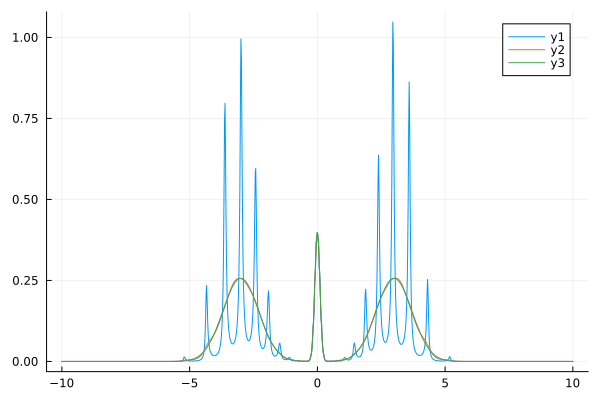

In [32]:
plot()
plot!(real.(wo_sol.reals.freq), imag.(wo_sol.reals.val)/pi)
plot!(Float64.(real.((sol.reals.freq))), Float64.(imag.(sol.reals.val))/pi)
plot!(omegas, rho.(omegas))
#savefig("picture.png")

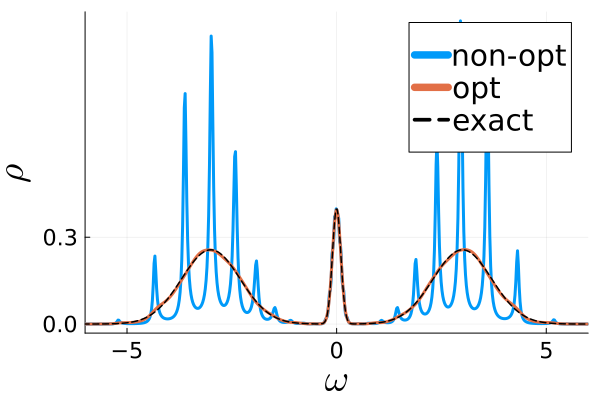

In [31]:
plot(xlim = [-6,6],
    legend = :topright,
    #ymirror = true, 
    xticks = [5,0,-5],
    yticks = [0.3,0,-0.3],
    xtickfont=font(15), 
    ytickfont=font(15), 
    guidefont=font(25), 
    legendfont=font(20))
plot!(xlabel=latexstring("\\omega"))
plot!(ylabel=latexstring("\\rho"))
plot!(real.(wo_sol.reals.freq), imag.(wo_sol.reals.val/pi),label="non-opt",lw=3)
plot!(Float64.(real.((sol.reals.freq))), Float64.(imag.(sol.reals.val)/pi),label="opt",lw=3)
plot!(omegas, rho.(omegas), label="exact",lw=1.5,ls=:dash,lc=:black)
#savefig("two_peak.svg")